# Loading IQ signal data

In [13]:
%load_ext autoreload
%autoreload 2

from gpsdec import SignalLoader
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# https://github.com/osqzss/gps-sdr-sim
# ./gps-sdr-sim.exe -e brdc3630.24n -l 47.062148,15.443774,120 -b 8 -d 31 -o gpssim_360_31sec_8bit.bin
true_position = (47.062148, 15.443774)
filename = 'recordings/gpssim_360_31sec_8bit.bin'
sample_rate, signal_iq_data = SignalLoader.load_gps_sym(filename, 2_600_000, np.int8)

# Wav recording, for example from sdrpp
# filename = 'recordings/gps_baseband_1575420000Hz.wav'
# sample_rate, signal_iq_data = SignalLoader.iq_wav_loader(filename, np.int16)

# Can be created from gnu radio like: https://zenodo.org/records/6394603
# filename = 'recordings/GPS-L1-2022-03-27'
# sample_rate, signal_iq_data = SignalLoader.sigmf_loader(filename)

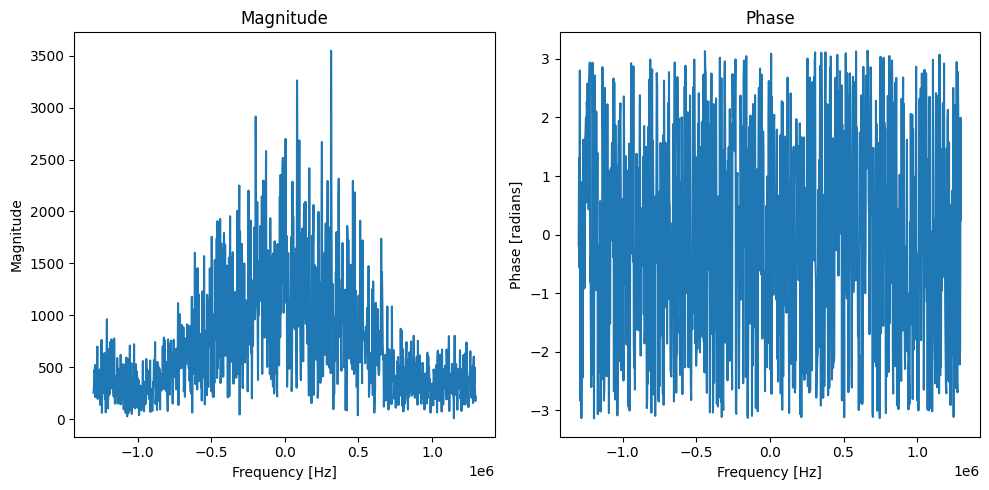

In [15]:
from gpsdec import visualization

visualization.signal_spectre(signal_iq_data[: 3 * sample_rate], sample_rate)

# Signal Acquisition

In [17]:
from gpsdec import RecieverSettings, AcquisitionComponent

my_settings = RecieverSettings(
    code_periods_to_process=30500,
    sampling_frequency=sample_rate,
)

acqusition_setup = AcquisitionComponent(my_settings, signal_iq_data)
acqusition_results = acqusition_setup.process()

100%|██████████| 32/32 [00:46<00:00,  1.45s/it]


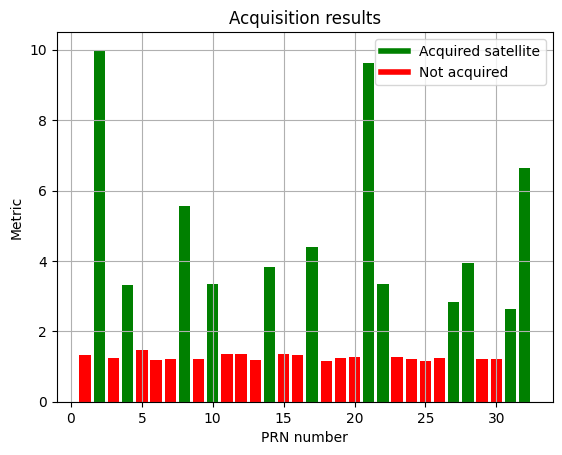

In [18]:
visualization.acquisition_information(acqusition_results)

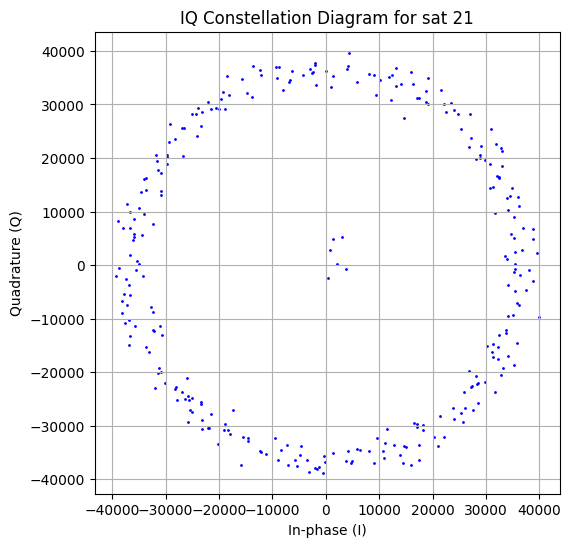

In [19]:
sat_to_show, ms_to_show = 21, 300

visualization.show_signal_iq_plot(
    signal_iq_data,
    acqusition_results[sat_to_show],
    my_settings,
    ms_to_show
)

# Signal tracking process

In [24]:
from gpsdec import TrackingComponent

good_satellites = [2, 8, 21, 32]

tracking_components = {}
for sat_to_proccess in good_satellites:
    satellite_acq_info = acqusition_results[sat_to_proccess]
    sat_tracker = TrackingComponent(signal_iq_data, satellite_acq_info, my_settings)
    sat_tracker.track()

    tracking_components[sat_to_proccess] = sat_tracker

100%|██████████| 30500/30500 [00:10<00:00, 2827.72it/s]


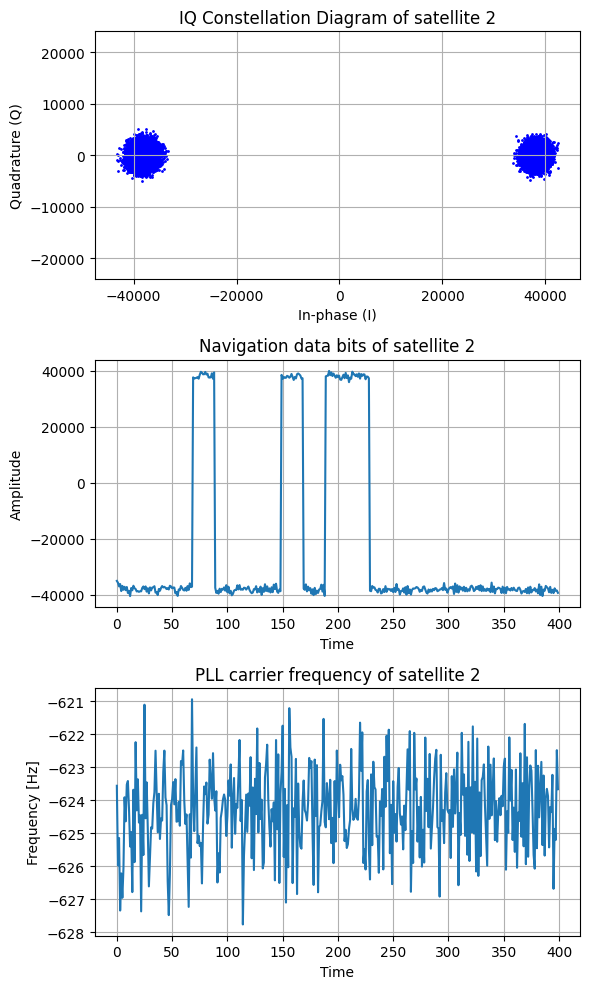

In [25]:
for sat_to_proccess in good_satellites:
    sat_tracker = tracking_components[sat_to_proccess]
    visualization.sat_tracker_results(sat_tracker)
    break

# Nav data decoding

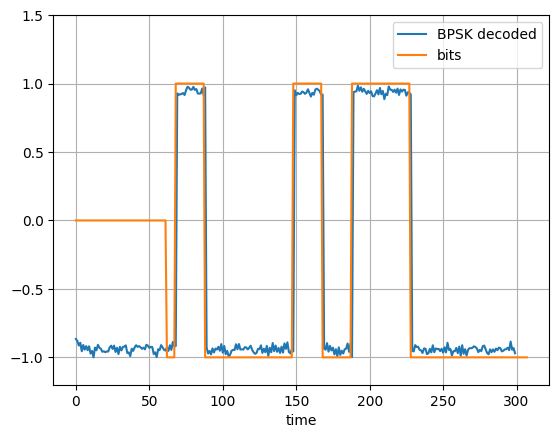

Found subframe: 1 with TOW: 86401
Found subframe: 2 with TOW: 86402
Found subframe: 3 with TOW: 86403
Found subframe: 4 with TOW: 86404
Found subframe: 5 with TOW: 86405
Acquired ephemeris of sat: 2
EphemerisParameters(week_number=298,
                    sat_accuracy=0,
                    sat_health=0,
                    issue_of_data_clock=86,
                    T_GD=-1.7695128917694092e-08,
                    t_oc=518400,
                    a_f2=0.0,
                    a_f1=8.981260180007666e-12,
                    a_f0=-0.0002818251959979534,
                    issue_of_data_emphemeris=86,
                    c_rs=-8.46875,
                    delta_n=4.624121184636698e-09,
                    m_0=2.886171784159632,
                    c_uc=-3.1851232051849365e-07,
                    e_s=0.01653307711239904,
                    c_us=0.0,
                    sqrt_a_s=5153.683069229126,
                    t_oe=518400,
                    c_ic=2.998858690261841e-07,
        

In [26]:
from gpsdec import NavDataDecoder
from pprint import pprint

plot_decoded_nav_bits = True
ticks_skip_till_stable_error = 15

preamble_forward_subframes_to_check = 4
subframes_count_to_decode = 3
words_per_subframe = 10

nav_components: list[NavDataDecoder] = []
for sat_to_proccess in good_satellites:
    nav_decoder = NavDataDecoder(
        my_settings, tracking_components[sat_to_proccess], ticks_skip_till_stable_error
    )
    nav_decoder.decode_bits(plot_decoded_nav_bits)
    nav_decoder.locate_preamble(preamble_forward_subframes_to_check)

    nav_decoder.check_validity(subframes_count_to_decode * words_per_subframe)
    nav_decoder.decode_available_subframes()

    print(f"Acquired ephemeris of sat: {sat_to_proccess}")
    pprint(nav_decoder.current_ephemeris)
    print()
    
    plot_decoded_nav_bits = False
    nav_components.append(nav_decoder)

In [27]:
from gpsdec import PseudorangeSolver

position_solver = PseudorangeSolver(nav_components)
position_solver.extract_data()

estimated_position, clock_correction_s = position_solver.solve()

print(f"ECEF coordinates: {estimated_position}")
print(f"WGS84 coordinates: {position_solver.ecef_to_wgs84(*estimated_position)}")
print(f"Clock bias in miliseconds: {clock_correction_s * 1_000}")

ECEF coordinates: [4195539.52077521 1159131.15231569 4646580.61130127]
WGS84 coordinates: (47.06224879299814, 15.44425254083533, 135.15659424103796)
Clock bias in miliseconds: -69.42215318763499


In [29]:
visualization.show_solution(position_solver, true_position)